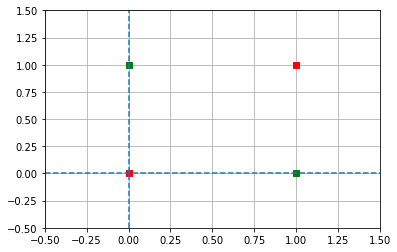

In [1]:
# A notebook alapú megjelenítés aktiválása
%matplotlib inline
import matplotlib.pyplot as plt # Pylab grafikus megjelenítocsomag importálása

# "Igaz" logikai értékek megadása
true_x = [1, 0]
true_y = [0, 1]

# "Hamis" logikai értékek megadása
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Négyzetrács megjelenítése
plt.grid(True)

# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')

# Az ábra kirajzolása
plt.show()

In [0]:
import numpy as np
from sklearn import preprocessing
import copy

In [0]:
def activation(x):
    return 1 / (1 + np.exp(-x))

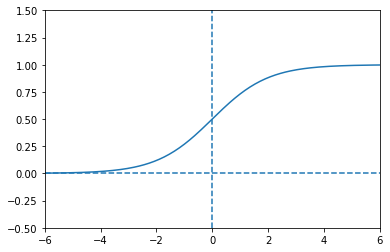

In [4]:
segedX=np.linspace(-6,6,200)
# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

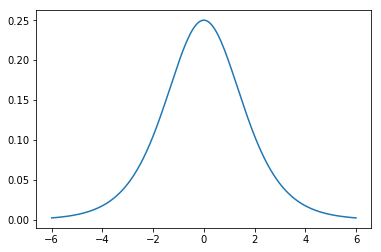

In [5]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

In [0]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (később pl. a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Súlyok újrainicializálása
        self.reset()
    
    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    
    def propagate_backward(self, target, lrate=0.1, alpha=0, l1=0, l2=0):
        deltas = []
        # Hiba kiszámítása a kimeneti rétegen
        error = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
            
            #HW momentum
            dw=dw+alpha*self.weights[i]
            #end of momentum
            
            #HW l1 method
            l1_cost=0
            l1_cost=l1_cost+l1*np.abs(self.weights[i]).sum()
            dw = dw-lrate*dw-lrate*l1*np.sign(self.weights[i])
            #end of l1 method
            
            #HW l2 method
            l2_cost=0
            l2_cost=l2 * 0.5 * np.square(self.weights[i]).sum()
            dw =dw - lrate * l2 * self.weights[i]
            #end of l2 method
            
            self.weights[i] += dw
            
            # a súlymódosítás eltárolása
            self.dw[i] = dw
        cost=(error**2).sum()
        # Visszatérés a hibával
        return cost+l1_cost+l2_cost

In [0]:
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1, l1=0, l2=0, alpha=0):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        randperm = np.random.permutation(len(X_valid))
        X_valid, Y_valid = X_valid[randperm], Y_valid[randperm]
        randperm = np.random.permutation(len(X_test))
        X_test, Y_test = X_test[randperm], Y_test[randperm]
        
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [0]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

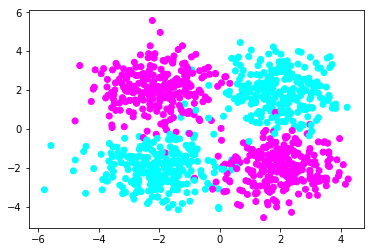

In [97]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

0 epoch, train_err: 0.2712, valid_err: 0.2447
1 epoch, train_err: 0.2437, valid_err: 0.2343
2 epoch, train_err: 0.2314, valid_err: 0.2196
3 epoch, train_err: 0.2132, valid_err: 0.1983
4 epoch, train_err: 0.1876, valid_err: 0.1706
5 epoch, train_err: 0.1569, valid_err: 0.1411
6 epoch, train_err: 0.1273, valid_err: 0.1157
7 epoch, train_err: 0.1037, valid_err: 0.0970
8 epoch, train_err: 0.0867, valid_err: 0.0840
9 epoch, train_err: 0.0750, valid_err: 0.0750
10 epoch, train_err: 0.0668, valid_err: 0.0686
11 epoch, train_err: 0.0608, valid_err: 0.0639
12 epoch, train_err: 0.0564, valid_err: 0.0604
13 epoch, train_err: 0.0530, valid_err: 0.0577
14 epoch, train_err: 0.0503, valid_err: 0.0555
15 epoch, train_err: 0.0481, valid_err: 0.0537
16 epoch, train_err: 0.0462, valid_err: 0.0523
17 epoch, train_err: 0.0447, valid_err: 0.0510
18 epoch, train_err: 0.0434, valid_err: 0.0500
19 epoch, train_err: 0.0422, valid_err: 0.0490

--- TESZTELÉS ---

0 [ 0.45148347 -0.9437387 ] 0.84  (elvart eredmeny

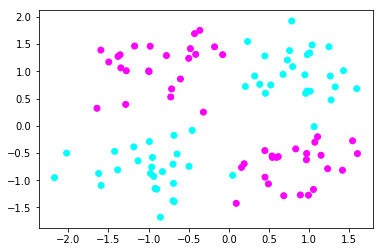

In [106]:
# learn with no regularisation and momentum
network.reset()
learn(network, X, Y, 0.2, 0.1, 20)

In [107]:
network.weights

[array([[-2.72823724, -0.11543375, -1.41332587,  2.0350076 , -0.92891452,
          1.00242925, -2.61514098,  1.81346946,  0.43950458,  1.85692553],
        [-2.29881852,  0.10985225,  1.19527529, -2.28064223, -1.33197844,
         -1.23840368,  2.45983311,  1.6004312 ,  0.53607948,  2.19247175],
        [ 2.7765745 ,  0.54379321,  1.3542076 ,  1.91326479, -1.00746588,
          0.68049032,  2.6619822 , -1.95791523,  0.71208978,  2.11662735]]),
 array([[ 4.32781869],
        [ 0.80869893],
        [-1.13271975],
        [-3.03995711],
        [-1.43471431],
        [-0.84688954],
        [-3.68572413],
        [-1.82404094],
        [ 0.79319921],
        [ 3.69813841]])]

0 epoch, train_err: 0.2784, valid_err: 0.2666
1 epoch, train_err: 0.2584, valid_err: 0.2551
2 epoch, train_err: 0.2523, valid_err: 0.2517
3 epoch, train_err: 0.2505, valid_err: 0.2505
4 epoch, train_err: 0.2498, valid_err: 0.2499
5 epoch, train_err: 0.2493, valid_err: 0.2494
6 epoch, train_err: 0.2489, valid_err: 0.2489
7 epoch, train_err: 0.2485, valid_err: 0.2485
8 epoch, train_err: 0.2481, valid_err: 0.2482
9 epoch, train_err: 0.2477, valid_err: 0.2478
10 epoch, train_err: 0.2474, valid_err: 0.2474
11 epoch, train_err: 0.2470, valid_err: 0.2470
12 epoch, train_err: 0.2466, valid_err: 0.2466
13 epoch, train_err: 0.2462, valid_err: 0.2462
14 epoch, train_err: 0.2458, valid_err: 0.2458
15 epoch, train_err: 0.2454, valid_err: 0.2453
16 epoch, train_err: 0.2450, valid_err: 0.2449
17 epoch, train_err: 0.2446, valid_err: 0.2445
18 epoch, train_err: 0.2441, valid_err: 0.2440
19 epoch, train_err: 0.2437, valid_err: 0.2435

--- TESZTELÉS ---

0 [ 0.54332732 -0.58005466] 0.51  (elvart eredmeny

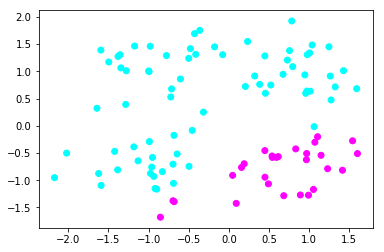

In [110]:
#learning with l1=0.007 l2=0.05 and momentum=0.7
network.reset()
learn(network, X, Y, 0.2, 0.1, 20,0.007,0.05,0.7)

In [111]:
network.weights

[array([[ 0.37081347, -0.63298362, -0.27630468,  0.29426515, -0.90734154,
         -0.88455053, -0.08065985, -0.41234717,  0.61304751, -0.07338471],
        [ 0.59419478, -0.50920187, -0.95153374,  0.85103922, -0.19988859,
          0.46811664, -0.0537553 ,  0.48276239,  0.28681809,  0.04587102],
        [-0.63826228,  0.65861078,  0.00327642, -0.34653496, -0.24908642,
          0.75820126, -0.61592251,  0.30341795, -0.18541785, -0.34120095]]),
 array([[-0.02083199],
        [ 1.05857416],
        [-0.88842534],
        [-0.63262062],
        [ 0.34956479],
        [-0.82122058],
        [ 0.49227996],
        [ 0.43518077],
        [ 0.68225305],
        [-0.80829931]])]